In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold

boston=load_boston
X_data,t=load_boston(return_X_y=True) 
# split the data into training and validation set   
X_train, X_valid, t_train, t_valid = train_test_split(X_data,t,test_size=1/5, random_state=10) 

In [2]:
def getRMSE(X_train,X_valid,t_train,t_valid, arg):
    Xtr = getTrainingSet(X_train, arg)    # add a column of one
    A = np.dot(Xtr.T,Xtr)
    A1 = np.linalg.inv(A) #the inverse of A
    B = np.dot(Xtr.T,t_train)
    w =np.dot(A1,B)
    y = np.dot(Xtr,w)
    
    # prepare the validation set
    Xva = getTrainingSet(X_valid, arg)
    y_valid = np.dot(Xva,w)
    diff_valid = np.subtract(t_valid,y_valid)
    err_valid = np.dot(diff_valid, diff_valid)/len(X_valid)
    RMSE_valid = np.sqrt(err_valid)

    return RMSE_valid

def getTrainingSet(X, arg): # 0: orginal, 1:sqrt, 2:square
    size=X.shape
    Xtr=np.ones( (size[0],1) )

    if (arg == 0):
        if (X.ndim == 1):
            Xtr=np.column_stack((Xtr, X))
        else: 
            for j in range(size[1]):
                Xtr=np.column_stack((Xtr, X[:,j]))
    elif (arg == 1):
            if (X.ndim == 1):
                Xtr=np.column_stack((Xtr, np.sqrt(X)))
                
            else:
                for j in range(size[1]):
                    Xtr=np.column_stack((Xtr, np.sqrt(X[:,j])))

    elif (arg == 2):
            if (X.ndim == 1):
                Xtr=np.column_stack((Xtr, np.square(X)))
                
            else:
                for j in range(size[1]):
                    Xtr=np.column_stack((Xtr, np.square(X[:,j])))    

    return Xtr


In [3]:
def kFold(splits, X, t, arg):
    res = 0
    kf=KFold(n_splits=splits)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        t_train, t_test = t[train_index], t[test_index]

        res = res + getRMSE(X_train,X_test,t_train,t_test, arg)
  
    error = res/splits

    return error    

In [4]:

def main (X_train, X_valid, t_train, t_valid, K, arg):

    kfError=np.zeros((K,1)) 
    tError=np.zeros((K,1))
    error = np.zeros((K,1))
    existingCol = np.arange(K)

    for i in range(K):
        
        if (i==0):
            for j in existingCol:

                X_train_temp=X_train[:,j]  # only select a column for the first run 
                error[j] = kFold(5, X_train_temp, t_train, arg)      

            S = X_train[:,np.argmin(error)]
            S_valid = X_valid[:,np.argmin(error)]

            kfError[i] = error[np.argmin(error)]
            tError[i] = getRMSE(S,S_valid,t_train,t_valid, arg)

            existingCol_new =np.delete(existingCol,np.where(existingCol == np.argmin(error) ))
            existingCol = existingCol_new
            #print(error,np.argmin(error) )
            error = np.full((K,1),np.inf)

        else:
            for j in existingCol:
                
                X_train_temp = np.column_stack( (S,np.reshape(X_train[:,j], (len(X_train), 1))) ) #######
                error[j] = kFold(5, X_train_temp, t_train, arg)
    
            S = np.column_stack( (S,  np.reshape(X_train[:,np.argmin(error)], (len(X_train), 1))) )
            S_valid = np.column_stack( (S_valid,  np.reshape(X_valid[:,np.argmin(error)], (len(X_valid), 1))) )

            kfError[i] = error[np.argmin(error)]
            tError[i] = getRMSE(S,S_valid,t_train,t_valid, arg)

            existingCol_new =np.delete(existingCol,np.where(existingCol == np.argmin(error) ))
            existingCol = existingCol_new
            print("When k=",i+1,", error for each selected feature=",np.reshape(error,(1,13)),". Smallest column index=",np.argmin(error) )
            error = np.full((K,1),np.inf)

    return kfError, tError




When k= 2 , error for each selected feature= [[6.20098095 6.20150039 6.1267174  6.38959859 6.0143877         inf
  6.00278365 6.31098621 5.99575417 5.88850501 5.89807577 5.91760715
  5.66791051]] . Smallest column index= 12
When k= 3 , error for each selected feature= [[5.56075872 5.5604055  5.64103173 5.65554656 5.61052229        inf
  5.64999387 5.67931524 5.56704276 5.51225088 5.28528497 5.42970652
         inf]] . Smallest column index= 10
When k= 4 , error for each selected feature= [[5.20522117 5.26064509 5.29499093 5.29836568 5.20254554        inf
  5.30061653 5.2885388  5.30768602 5.2779855         inf 5.06595332
         inf]] . Smallest column index= 11
When k= 5 , error for each selected feature= [[5.02317595 5.05224069 5.08642522 5.08668289 5.05575559        inf
  5.09693526 5.05442123 5.10347156 5.09847492        inf        inf
         inf]] . Smallest column index= 0
When k= 6 , error for each selected feature= [[       inf 5.00645208 5.04117981 5.046233   5.01405418    

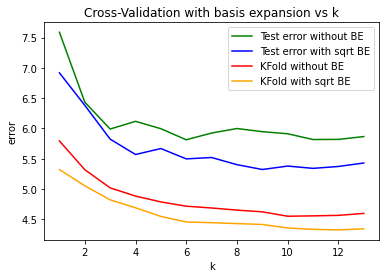

In [5]:
K=13 
k_index = np.arange(K)+1
kfError_BE2, tError_BE2 = main (X_train, X_valid, t_train, t_valid, K, 2)
kfError_BE, tError_BE = main (X_train, X_valid, t_train, t_valid, K, 1)
kfError, tError = main (X_train, X_valid, t_train, t_valid, K, 0)
plt.plot(k_index, tError, color = 'green', label = 'Test error without BE')
plt.plot(k_index, tError_BE, color = 'blue', label = 'Test error with sqrt BE')
plt.plot(k_index, kfError, color = 'red', label = 'KFold without BE')
plt.plot(k_index, kfError_BE, color = 'orange', label = 'KFold with sqrt BE')


plt.xlabel("k")
plt.ylabel("error")
#plt.title("Cross-Validation and Test error vs k")
plt.title("Cross-Validation with basis expansion vs k")
plt.legend()
